In [1]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

import geemap
import json
from ipyleaflet import GeoJSON, Marker, MarkerCluster
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from skimage import exposure
import cv2
import os



LANDSAT_5 = "LANDSAT/LT05/C02/T1_L2"
LANDSAT_5_START = 1984
LANDSAT_5_END = 2000

LANDSAT_7 = "LANDSAT/LE07/C02/T1_L2"
LANDSAT_7_START = 2000
LANDSAT_7_END = 2014

LANDSAT_8 = "LANDSAT/LC08/C02/T1_L2"
LANDSAT_8_START = 2014
LANDSAT_8_END = 2022

def apply_scale_factors_57(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)
    
    image = (image.addBands(opticalBands, None, True)
              .addBands(thermalBand, None, True))
    image = (image.select(["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7", "ST_B6", "QA_PIXEL"])
                .rename(["B1", "B2", "B3", "B4", "B5", "B7", "ST", "QA_PIXEL"]))
    return image


def apply_scale_factors_8(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    
    image = (image.addBands(opticalBands, None, True)
              .addBands(thermalBand, None, True))
    image = (image.select(["SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "ST_B10", "QA_PIXEL"])
                .rename(  ["B1",    "B2",    "B3",    "B4",    "B5",    "B7",    "ST",     "QA_PIXEL"]))
    return image

def mask_clouds(image):
    qa = image.select("QA_PIXEL")
    
    mask = (qa.bitwiseAnd(1 << 3).And(qa.bitwiseAnd(1 << 9))
            .Or(qa.bitwiseAnd(1 << 4).And(qa.bitwiseAnd(1 << 11)))
            .Or(qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 13)))
           )
    
    image = image.updateMask(mask.Not())    
    
    return image


image_ls_8 = (ee.ImageCollection(LANDSAT_8)
                .map(apply_scale_factors_8)
                .map(mask_clouds)
             )

COMBINED_LANDSAT = image_ls_8

In [2]:
def create_bounding_box(point: ee.Geometry.Point, diameter: float):
    intermediate_circle = point.buffer(diameter/2.0, 0.0)
    return intermediate_circle.bounds()


# Amberg: 11.8633, 49.4403
# Keelung: 121.7392, 25.1276
# Pohang-si: 129.3145, 36.0030 (Works)
# Bangkok: 100.5018, 13.7563 (Sadly Poor data in 1984)
# Hanoi: 105.8342 21.0278
# Shenzhen: 114.0596, 22.5429
# HongKong: 114.1694, 22.3193
# Nairobi: 36.8219, 1.2921


# Atami: 35.0985444,139.0690813
CITY = ee.Geometry.Point([139.0690813, 35.0985444]) # Coord format: E, N 

CITY_BOUNDING_BOX = create_bounding_box(CITY, 14000)
YEAR = 2013

Map = geemap.Map()

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
ls_read = (COMBINED_LANDSAT
            .filterBounds(CITY)
            .filterDate(f'{YEAR}-01-01', f'{YEAR}-12-31')
            .map(mask_clouds)
           )
ls_median = ls_read.median()

data_available = ls_median.getInfo() is not None

print("Data Available: ", data_available)

if data_available:
    vis_params_wc = {"bands": ['Map']}
    vis_params_rgb = {'bands': ['B3', "B2", "B1"], "min": 0, "max": 0.3, 'opacity': 1.0}
    #vis_params = {'bands': ['ST'], 'palette': ['9d3d21', ' 2b5b8a'], 'min': 260.0, 'max': 380.0, 'opacity': .8}
    Map.centerObject(CITY, 14)
    Map.addLayer(ls_median, vis_params_rgb, f"Satelite Image")
    #Map.addLayer(wc_read, vis_params_wc, f"World Cover Map")
    #Map.addLayer(ls_median, vis_params, f"Thermal Band")

Data Available:  True


In [4]:
print(Map.chart_labels)

None


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


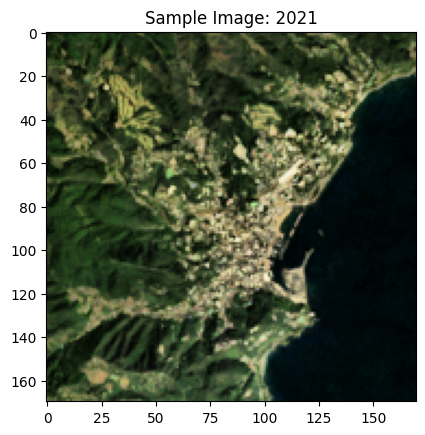

In [14]:
YEAR = 2021
CITY_BOUNDING_BOX = create_bounding_box(CITY, 5000)
ls_read = (COMBINED_LANDSAT
            .filterBounds(CITY)
            .filterDate(f'{YEAR}-01-01', f'{YEAR}-12-31')
            .map(mask_clouds)
           )
ls_median = ls_read.median()


ls_read_export = ls_median.reproject(ls_read.first().select("B1").projection())
channel = geemap.ee_to_numpy(ls_read_export, region=CITY_BOUNDING_BOX, bands = ['B3', "B2", "B1"], default_value=0.0)
image = exposure.equalize_adapthist(channel, clip_limit=0.02)


plt.title(f"Sample Image: {YEAR}")
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


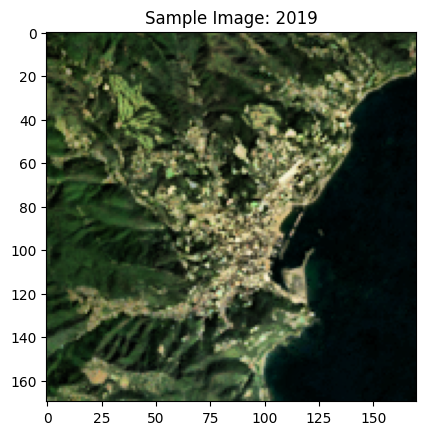

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


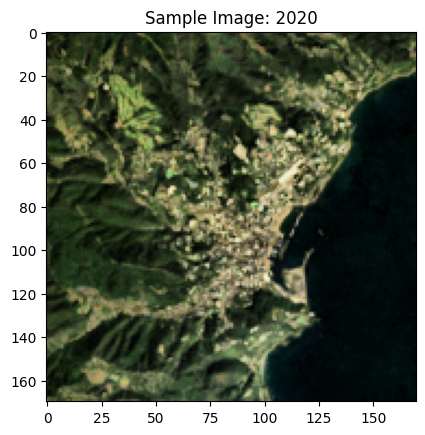

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


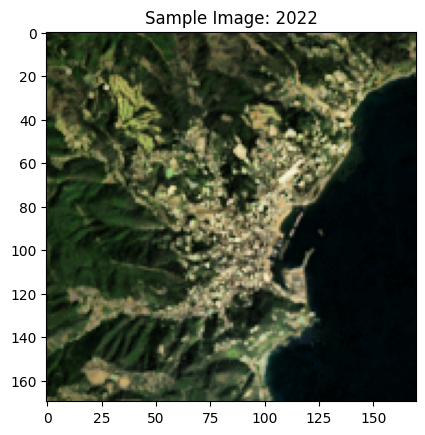

In [15]:
YEAR = 2019
ls_read = (COMBINED_LANDSAT
            .filterBounds(CITY)
            .filterDate(f'{YEAR}-01-01', f'{YEAR}-12-31')
            .map(mask_clouds)
           )
ls_median = ls_read.median()


ls_read_export = ls_median.reproject(ls_read.first().select("B1").projection())
channel = geemap.ee_to_numpy(ls_read_export, region=CITY_BOUNDING_BOX, bands = ['B3', "B2", "B1"], default_value=0.0)
image_2019 = exposure.equalize_adapthist(channel, clip_limit=0.02)

YEAR = 2020
ls_read = (COMBINED_LANDSAT
            .filterBounds(CITY)
            .filterDate(f'{YEAR}-01-01', f'{YEAR}-12-31')
            .map(mask_clouds)
           )
ls_median = ls_read.median()


ls_read_export = ls_median.reproject(ls_read.first().select("B1").projection())
channel = geemap.ee_to_numpy(ls_read_export, region=CITY_BOUNDING_BOX, bands = ['B3', "B2", "B1"], default_value=0.0)
image_2020 = exposure.equalize_adapthist(channel, clip_limit=0.02)

YEAR = 2022
ls_read = (COMBINED_LANDSAT
            .filterBounds(CITY)
            .filterDate(f'{YEAR}-01-01', f'{YEAR}-12-31')
            .map(mask_clouds)
           )
ls_median = ls_read.median()


ls_read_export = ls_median.reproject(ls_read.first().select("B1").projection())
channel = geemap.ee_to_numpy(ls_read_export, region=CITY_BOUNDING_BOX, bands = ['B3', "B2", "B1"], default_value=0.0)
image_2022 = exposure.equalize_adapthist(channel, clip_limit=0.02)


plt.title(f"Sample Image: 2019")
plt.imshow(image_2019)
plt.show()

plt.title(f"Sample Image: 2020")
plt.imshow(image_2020)
plt.show()

plt.title(f"Sample Image: 2022")
plt.imshow(image_2022)
plt.show()

In [4]:
def norm_minmax(band, min_max=None):
    if min_max is None:
        band_min, band_max = band.min(), band.max()
    else:
        band_min, band_max = min_max
    return ((band - band_min)/(band_max - band_min)), (band_min, band_max)

def norm(band, min_max=None):
    if min_max is None:
        band_min, band_max = band.min(), band.max()
    else:
        band_min, band_max = min_max
    return ((band - band_min)/(band_max - band_min))

def create_timelaps_data(point, years, verbose=True):
    bounding_box = create_bounding_box(point, 14000) # We cant export more ATM
    resulting_images = []
    for year in years:
        if verbose:
            print(f"At Year: {year}")
        ls_read = (COMBINED_LANDSAT
                .filterBounds(point)
                .filterDate(f'{year}-01-01', f'{year+1}-01-01')
                .map(mask_clouds)
               )
        ls_median = ls_read.median()
        ls_read_export = ls_median.reproject(ls_read.first().select("B1").projection())

        image = geemap.ee_to_numpy(ls_read_export, region=bounding_box, bands = ["B1", "B2", "B3", "B4", "B5", "B7"], default_value=0.0)
        resulting_images.append((image))
    return np.asarray(resulting_images)


def create_training_data(years, verbose=True):
    for year in years:
        ls_read = (COMBINED_LANDSAT
                    .filterDate(f'{year}-01-01', f'{year+1}-01-01')
                    .map(mask_clouds)
                   )
        

YEARS = list(range(2013, 2019))
MONTHS = [(1, 12)]

DATA_SET_EXISTS = os.path.isfile("city_dataset/DATA_raw.npy")
print(f"Cached dataset {DATA_SET_EXISTS}")
if DATA_SET_EXISTS:
    DATA_SET = TIMELAPS_IMAGES = np.load("city_dataset/DATA_raw.npy")
else:
    DATA_SET = TIMELAPS_IMAGES = create_timelaps_data(CITY, YEARS, months=MONTHS)
    np.save("city_dataset/DATA_raw", DATA_SET)
print("Done!")

Cached dataset True
Done!


In [5]:
ch_minmax = {}
for ch in range(6):
    DATA_SET[:, :, :], ch_minmax[ch] = norm_minmax(norm(DATA_SET[:, :, :]))
    

TRAIN_SET = np.reshape(DATA_SET[:, :, :, :], (DATA_SET.shape[0]*DATA_SET.shape[1]*DATA_SET.shape[2], DATA_SET.shape[3]))
#TRAIN_SET = np.reshape(DATA_SET[0, :, :, :], (DATA_SET.shape[1]*DATA_SET.shape[2], DATA_SET.shape[3]))
print(TRAIN_SET.shape)
np.random.shuffle(TRAIN_SET)
print(TRAIN_SET.shape)

(1314138, 6)
(1314138, 6)


In [6]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
if False:
    N_CLUSTER = 6
    N_REPS = 20
    sse = {}
    siluette_score = {k : [] for k in range(3, N_CLUSTER)}

    for _ in range(N_REPS):
        print(_)
        index = np.random.choice(TRAIN_SET.shape[0], 10000, replace=False)  
        for k in range(3, N_CLUSTER):
            kmeans = KMeans(n_clusters=k).fit(TRAIN_SET[index])
            siluette_score[k].append(silhouette_score(TRAIN_SET[index], kmeans.labels_, metric='euclidean'))

    siluette_score_mean = {}
    siluette_score_std = {}
    for k in range(3, N_CLUSTER):
        siluette_score_mean[k] = np.mean(siluette_score[k])
        siluette_score_std[k] = np.std(siluette_score[k])
    plt.figure()
    #plt.plot(list(sse.keys()), list(sse.values()), label="sse")
    plt.errorbar(list(siluette_score.keys()), list(siluette_score_mean.values()), yerr=list(siluette_score_std.values()), label="silouette score")
    plt.legend()
    plt.xlabel("Number of cluster")
    plt.ylabel("Silouette Coefficient")
    plt.show()    

In [7]:
kmeans = KMeans(n_clusters=4).fit(TRAIN_SET)

In [8]:
DATA_SET_EXISTS = os.path.isfile("city_dataset/TEST_raw.npy")
if not DATA_SET_EXISTS:
    TEST_SET = create_timelaps_data(CITY, list(range(2020, 2021)))
    np.save("city_dataset/TEST_raw", TEST_SET)
else:
    TEST_SET = np.load("city_dataset/TEST_raw.npy")
print(TEST_SET.shape)

(1, 469, 467, 6)


0


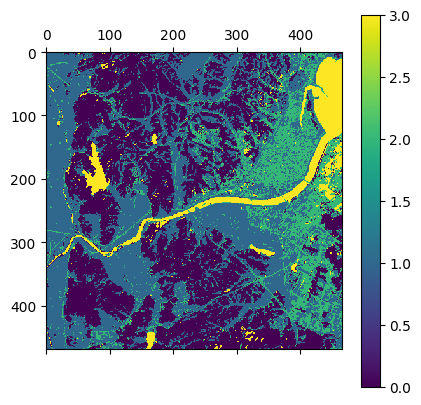

In [9]:
for year in range(TEST_SET.shape[0]):
    print(year)
    for ch in range(6):
        TEST_SET[year, :, :] = norm(TEST_SET[year, :, :], min_max=ch_minmax[ch])
    

test_img = TEST_SET[0]
test_img = test_img.reshape((test_img.shape[0]*test_img.shape[1], test_img.shape[2]))

test_classification = kmeans.predict(test_img)
test_classification = test_classification.reshape((DATA_SET[0].shape[0], DATA_SET[0].shape[1], 1))

plt.matshow(test_classification)
plt.colorbar()
plt.show()

0 50
1 80
2 40
3 10


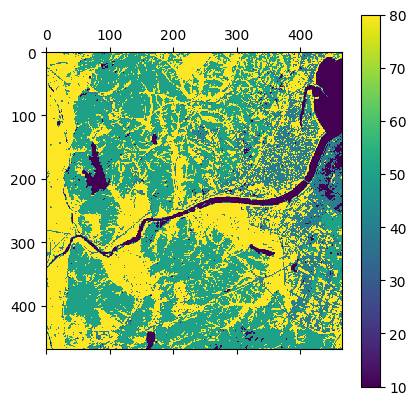

In [10]:
CLUSTER_ASSIGNMENT = {
    0 : 50,
    1 : 80,
    2 : 40,
    3 : 10
}

for k, v in CLUSTER_ASSIGNMENT.items():
    print(k, v)
    test_classification[test_classification == k] = v
    
plt.matshow(test_classification)
plt.colorbar()
plt.show()

In [11]:
year_frame = np.dstack((TEST_SET[0, :, :, 2], TEST_SET[0, :, :, 1], TEST_SET[0, :, :, 0]))
#year_frame = norm(year_frame)
image = exposure.equalize_adapthist(year_frame[:], clip_limit=0.02)

In [12]:
DOWNLOAD = False
if DOWNLOAD:
    from terracatalogueclient import Catalogue 
    from shapely.geometry import Polygon 


    # create catalogue object and authenticate 
    catalogue = Catalogue().authenticate() 
    products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_v100_N33E129") 


    bounds = CITY_BOUNDING_BOX.coordinates().getInfo()
    print(bounds)
    geometry = Polygon(bounds[0])

    products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry) 
    catalogue.download_products(products, "worldcover") 



In [13]:
def create_projection_window(bounding_box):
    coords = np.asarray(bounding_box.getInfo()["coordinates"])[0]    
    lat_max = np.max(coords[:, 0])
    lat_min = np.min(coords[:, 0])
    
    lon_max = np.max(coords[:, 1])
    lon_min = np.min(coords[:, 1])
    return [lat_min, lon_max, lat_max, lon_min]

proj_window = create_projection_window(CITY_BOUNDING_BOX)

['./worldcover/ESA_WorldCover_10m_2020_v100_N36E129/ESA_WorldCover_10m_2020_v100_N36E129_Map.tif', './worldcover/ESA_WorldCover_10m_2020_v100_N33E129/ESA_WorldCover_10m_2020_v100_N33E129_Map.tif']


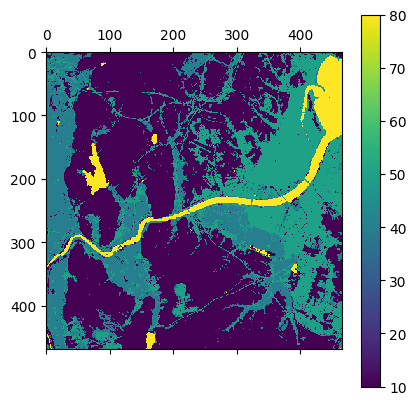

In [14]:
from osgeo import gdal
import os
import glob

file_list = glob.glob("./worldcover/*/*Map.tif")

files_string = " ".join(file_list)
print(file_list)
my_vrt = gdal.BuildVRT('./worldcover/combined.vrt', file_list)
ds = gdal.Translate('./worldcover/cropped.vrt', my_vrt, projWin=proj_window, 
                                                       width=image.shape[1], 
                                                       height=image.shape[0])
ground_truth_data = ds.ReadAsArray()
ds = None

GROUND_TRUTH_COMBINATION = {
    10:  10,
    20:  10,
    30:  10,
    90:  10,
    95:  10,
    100: 10,
    
    60: 40,
    40: 40,
    
    70: 80,
    80: 80,
    
    50: 50
    
}

for k, v in GROUND_TRUTH_COMBINATION.items():
    ground_truth_data[ground_truth_data == k] = v
    
plt.matshow(ground_truth_data)
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


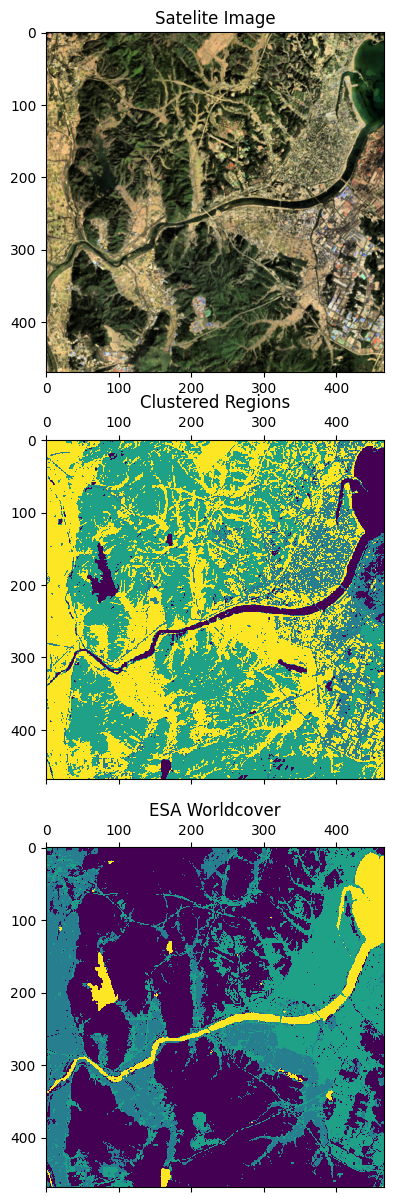

In [15]:

#plt.figure(8, 8)
fig, axarr = plt.subplots(3,1)

fig.set_figheight(15)
fig.set_figwidth(20)
axarr[0].set_title("Satelite Image")
axarr[0].imshow(image)
axarr[1].set_title("Clustered Regions")
axarr[1].matshow(test_classification)
axarr[2].set_title("ESA Worldcover")
axarr[2].matshow(ground_truth_data)
#plt.show()
plt.savefig("clusted_example.png")

<AxesSubplot: >

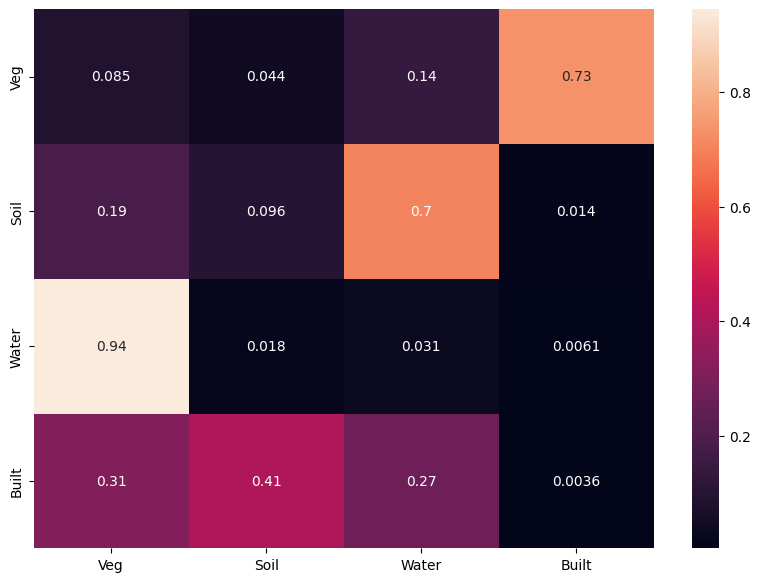

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd



cm = confusion_matrix(test_classification.flatten(), ground_truth_data.flatten(), labels=[10, 40, 50, 80], normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in ["Veg", "Soil", "Water", "Built"]],
                  columns = [i for i in ["Veg", "Soil", "Water", "Built"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [17]:
print(ground_truth_data.shape)
print(image.shape)
print(test_classification.shape)

(469, 467)
(469, 467, 3)
(469, 467, 1)


In [18]:
bands = []
band_label = []
for i in range(1, image.shape[0]-1):
    for j in range(1, image.shape[1]-1):
        bands.append(TEST_SET[0, i-1:i+2, j-1:j+2].reshape(9*6))
        band_label.append(ground_truth_data[i, j])
bands = np.asarray(bands)
band_label = np.asarray(band_label)
print(bands.shape, band_label.shape)

(217155, 54) (217155,)


/Users/davidwinderl/miniconda/envs/eeg/lib/python3.8/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(10000, 2)


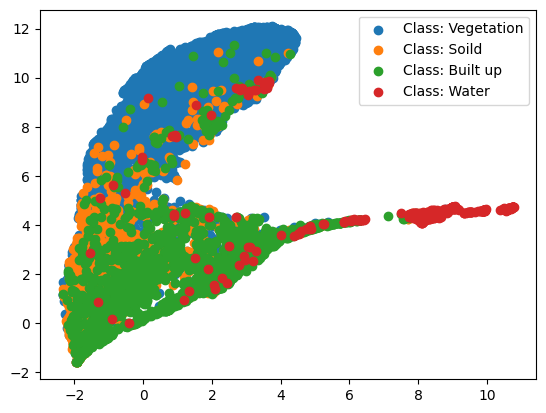

In [19]:
import umap
import numba


index = np.random.choice(bands.shape[0], 10000, replace=False)  
data_pints_umap = bands[index]
labels_umap = band_label[index]

weight_matrix = np.asarray([
    [1.0, 1.0, 1.0],
    [1.0, 10.0, 1.0],
    [1.0, 1.0, 1.0]
])

weight_matrix = np.dstack([weight_matrix]*6)

@numba.njit()
def sparse_eucliden_dist(a, b):
    a = a.reshape(3, 3, 6)
    b = b.reshape(3, 3, 6)
    dist = ((a-b)*weight_matrix).flatten()
    return np.linalg.norm((dist).flatten(), 1)




u = umap.UMAP(n_neighbors=40,
                      min_dist=0.0,
                      metric=sparse_eucliden_dist).fit_transform(data_pints_umap)



print(u.shape)
def label_to_text(label):
    if label == 10:
        return "Vegetation"
    elif label == 40:
        return "Soild"
    elif label == 50:
        return "Built up"
    elif label == 80:
        return "Water"

for label in [10, 40, 50, 80]:
    label_idx = labels_umap == label
    plt.scatter(u[label_idx, 0], u[label_idx, 1], label=f"Class: {label_to_text(label)}")

plt.legend()
plt.show()

In [20]:
print(TEST_SET[0].shape)

np.save("region_image_bands", TEST_SET[0])
np.save("ground_truth_data", ground_truth_data)

DATA_SET = np.load("city_dataset/DATA_raw.npy")
np.save("train_region_image_bands_train", DATA_SET)

(469, 467, 6)
